In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
sns.set_style('whitegrid')

import scipy.signal as sigctrl_preproc
import scipy as sp
import os
from preproc_6ax_data import proc_parse_salto_clips_custom, resample_df_clips, load_and_preproc_data_single

#DATA_DIR = '/home/asya/Desktop/Gyro_Data/modeling/'
DATA_DIR = '../Gyro_Data/modeling/'

In [69]:
!pip install -q tensorflow==2.3.0
import tensorflow as tf

You should consider upgrading via the '/home/asya/anaconda3/envs/tflite/bin/python -m pip install --upgrade pip' command.


## Preprocess salto data
Clips of data for the 2 types of flips, aligned on a threshold crossing

folders renamed to salto_pike, salto_drop

In [70]:
## Preprocess the data to select individual salto clips
## write as files into folders ending with 'raw'
proc_parse_salto_clips_custom(t_pre = 1, t_post = 2, proc_nonsalto = False)

/home/asya/Desktop/Gyro_Data/bluepy_data/silks_preproc/0729_setup_eggbeater_salto_preproc.txt


In [71]:
## Resample the clips to 119Hz, and rewrite to new folders
#will be written to salto_pike_linear, salto_drop_linear
resample_df_clips(os.path.join(DATA_DIR,'salto_pike_raw'), interpolation_kind = 'linear',freq_new = 119.)
resample_df_clips(os.path.join(DATA_DIR,'salto_drop_raw'), interpolation_kind = 'linear',freq_new = 119.)

#will be written to salto_pike_quadratic, salto_drop_quadratic
resample_df_clips(os.path.join(DATA_DIR,'salto_pike_raw'), interpolation_kind = 'quadratic',freq_new = 119.)
resample_df_clips(os.path.join(DATA_DIR,'salto_drop_raw'), interpolation_kind = 'quadratic',freq_new = 119.)

In [72]:
## try plotting the salto traces

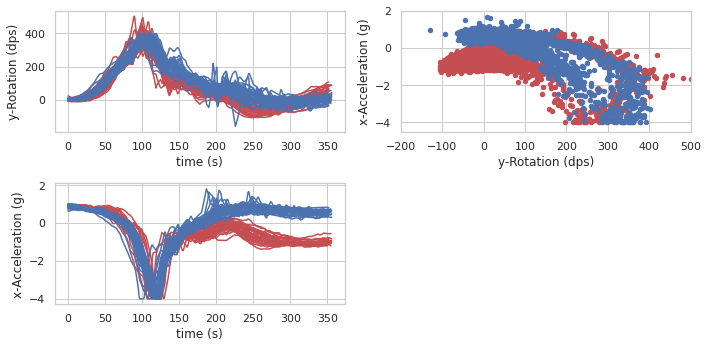

In [20]:
fig, ax = plt.subplots(2,2, figsize = (10,5))

flelist = glob.glob(DATA_DIR + 'salto_pike_linear/*')
color = 'r'
for fle in flelist:
    df_clip = pd.read_csv(fle)#.set_index('t')
    df_clip.gy.plot(ax = ax[0,0], color = color)
    df_clip.ax.plot(ax = ax[1,0], color = color)
    df_clip.loc[::5].plot.scatter(ax = ax[0,1],x = 'gy', y = 'ax', color = color)  
    
flelist = glob.glob(DATA_DIR + 'salto_drop_linear/*')
color = 'b'
for fle in flelist:
    df_clip = pd.read_csv(fle)#.set_index('t')
    df_clip.gy.plot(ax = ax[0,0], color = color)
    df_clip.ax.plot(ax = ax[1,0], color = color)
    df_clip.loc[::5].plot.scatter(ax = ax[0,1],x = 'gy', y = 'ax', color = color)
    
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('y-Rotation (dps)')
ax[1,0].set_ylabel('x-Acceleration (g)')

ax[0,1].set_xlabel('y-Rotation (dps)')
ax[1,1].set_xlabel('y-Rotation (dps)')
ax[0,1].set_ylabel('x-Acceleration (g)')
ax[1,1].set_ylabel('x-Acceleration (g)')
ax[1,1].set_xlim(-200,500)
ax[0,1].set_xlim(-200,500)
ax[1,1].set_ylim(-4.5, 2)
ax[0,1].set_ylim(-4.5, 2)

ax[0,0].set_xlabel('time (s)')
ax[1,0].set_xlabel('time (s)')

ax[1,1].axis('off')

fig.tight_layout()

In [6]:
%load_ext autoreload
%autoreload 2

## Preprocess control data 
Clips of data on the silks, and clips off the silks

In [73]:
from preproc_6ax_data import proc_parse_silks_clips_custom, proc_parse_ctrl_clips_custom

## parses out gaps in the data and writes to new files
proc_parse_silks_clips_custom()
proc_parse_ctrl_clips_custom()

Starting file index: 0
Error in file ../silks_preproc/0726_wheeldown_2_preproc.txt: Timing Error in clip 164


In [74]:
## Resample the clips to 119 Hz, and rewrite to new folders
resample_df_clips(os.path.join(DATA_DIR,'silks_raw'), interpolation_kind = 'linear', freq_new = 119.)
resample_df_clips(os.path.join(DATA_DIR,'ground_raw'), interpolation_kind = 'linear', freq_new = 119.)

resample_df_clips(os.path.join(DATA_DIR,'silks_raw'), interpolation_kind = 'quadratic', freq_new = 119.)
resample_df_clips(os.path.join(DATA_DIR,'ground_raw'), interpolation_kind = 'quadratic', freq_new = 119.)

## Split data for the model 
split the clips at this point into test, train, validation

clip to particular lengths (maybe better to find a way to do it in the dataloader)

In [83]:
!python data_split.py -s 50 -combinesalto y -interp linear

In [84]:
seq_length = 50

**Optional data testing**

In [12]:
from data_load import DataLoader


def load_data(train_data_path, valid_data_path, test_data_path, seq_length):
  data_loader = DataLoader(
      train_data_path, valid_data_path, test_data_path, seq_length=seq_length)
  data_loader.format()
  return data_loader.train_len, data_loader.train_data, data_loader.valid_len, \
      data_loader.valid_data, data_loader.test_len, data_loader.test_data

train_len, train_data, valid_len, valid_data, test_len, test_data = \
    load_data("../Gyro_Data/test_train_split/train",\
                  "../Gyro_Data/test_train_split/valid",\
                  "../Gyro_Data/test_train_split/test", seq_length)

In [13]:
print('Train: {}\nValid: {}\nTest:  {}'.format(train_len, valid_len, test_len))

Train: 16362
Valid: 5171
Test:  5142


In [14]:
import json
data = []
label = []
segment_type = 'random'
LABEL_NAME = "movement"
DATA_NAME = "accel_gyro_6ax"

with open("../Gyro_Data/test_train_split/train", "r") as f:
    lines = f.readlines()
    for idx, line in enumerate(lines):  # pylint: disable=unused-variable
        dic = json.loads(line)
        if dic['segment_type'] == segment_type:
            data.append(dic[DATA_NAME])
            label.append(dic[LABEL_NAME])

[1.4250692604869593, 0.01627880433563793, 0.2140206715342733, 181.10397568059165, 6702.9451555561645, 117.40636661551609]


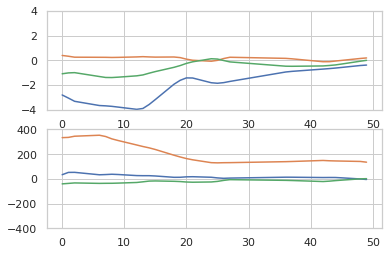

In [15]:
variances = []
for idx in range(len(data)):
    var_row = [np.var([a[i] for a in data[idx]]) for i in range(6)]
    variances.append(pd.DataFrame(var_row).T)
variances = pd.concat(variances)

for idx in range(10, len(data)):
    var_row = [np.var([a[i] for a in data[idx]]) for i in range(6)]
    cutoff = (var_row[0] < .5) & (var_row[1] < .5) &(var_row[2] < .5) &\
             (var_row[3] < 5e3) & (var_row[4] < 5e3) &(var_row[5] < 5e3)
    if not cutoff: 
        print(var_row)
        fig, ax = plt.subplots(2,1)
        ax[0].plot(np.asarray([a[0] for a in data[idx]]))
        ax[0].plot(np.asarray([a[1] for a in data[idx]]))
        ax[0].plot(np.asarray([a[2] for a in data[idx]]))
        ax[0].set_ylim([-4,4])        
        ax[1].plot(np.asarray([a[3] for a in data[idx]]))
        ax[1].plot(np.asarray([a[4] for a in data[idx]]))
        ax[1].plot(np.asarray([a[5] for a in data[idx]]))
        ax[1].set_ylim([-400,400])    
        break

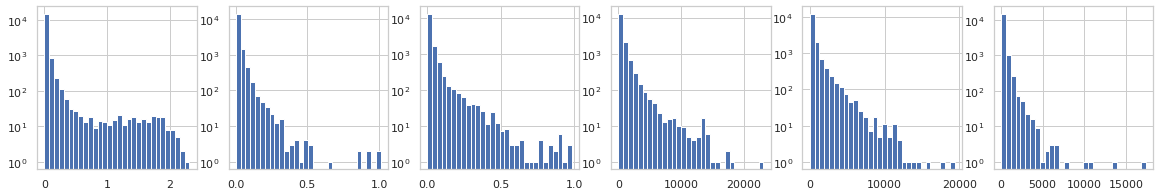

In [16]:
fig, ax = plt.subplots(1,6, figsize = (20,3))
for i in range(6):
    variances[i].hist(bins = 30, ax = ax[i])
    ax[i].set_yscale('log')

## Try a random forest modelsklearn.ensemble.RandomForestClassifier(n_estimators=100

In [50]:
import sys
!conda install --yes --prefix {sys.prefix} scikit-learn

Solving environment: done

## Package Plan ##

  environment location: /home/asya/anaconda3/envs/tflite

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-0.17.0              |             py_0         205 KB
    scikit-learn-0.23.2        |   py38h0573a6f_0         7.0 MB
    threadpoolctl-2.1.0        |     pyh5ca1d4c_0          16 KB
    ------------------------------------------------------------
                                           Total:         7.2 MB

The following NEW packages will be INSTALLED:

  joblib             pkgs/main/noarch::joblib-0.17.0-py_0
  scikit-learn       pkgs/main/linux-64::scikit-learn-0.23.2-py38h0573a6f_0
  threadpoolctl      pkgs/main/noarch::threadpoolctl-2.1.0-pyh5ca1d4c_0



threadpoolctl-2.1.0  | 16 KB     | ##################################### | 100% 
scikit-learn-0.23.2  | 7.0 MB    | #######

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
data = []
label = []
with open("../Gyro_Data/test_train_split/train", "r") as f:
    lines = f.readlines()
    for idx, line in enumerate(lines):  # pylint: disable=unused-variable
        dic = json.loads(line)
        if dic['segment_type'] == segment_type:
            if (dic[LABEL_NAME] == 'salto'):
                continue
            data.append([a[i] for i in range(6) for a in dic[DATA_NAME]])
            if (dic[LABEL_NAME] == 'silks'):
                label.append(1)
            else:
                label.append(0)

In [104]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(np.asarray(data), label)

RandomForestClassifier(max_depth=10, random_state=0)

In [105]:
pred = clf.predict(np.asarray(data))

In [106]:
sum(pred == label)/len(pred)

0.9456241561310912

In [107]:
sum(pred)/len(pred)

0.6976801276543513

In [100]:
pred.sum()

6463

## Train and output the model

In [17]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/scalars

# Notes:

145639: seq 100, batch 64, epochs 50, n/epoch 1000 adam(default)

152426: seq 100, batch 64, epochs 500, n/epoch 100 adam(default)

154018: eq 100, batch 64, epochs 50, n/epoch 1000 rmsprop(0.001)

162217: eq 100, batch 64, epochs 50, n/epoch 1000 rmsprop(0.01)

In [44]:
!python train.py --model CNN -s 50 -nout 3

2020-12-11 16:14:22.047902: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-12-11 16:14:22.047931: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-12-11 16:14:23.047019: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2020-12-11 16:14:23.047144: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
Start to load data...
2020-12-11 16:14:36.910527: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-12-11 16:14:36.910569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on t

In [19]:
from train import build_net, load_data, train_model, reshape_function, build_cnn

In [20]:
model, model_path = build_cnn(seq_length)
model.load_weights(os.path.join(model_path,'weights.h5'))

model CNN output categories: 3
sequence length
Built CNN.


In [30]:
_,_,_,_, test_len, test_data = \
        load_data("../Gyro_Data/test_train_split/train",\
                  "../Gyro_Data/test_train_split/valid",\
                  "../Gyro_Data/test_train_split/test", seq_length)

test_data = test_data.map(reshape_function)
test_labels = np.zeros(test_len)
idx = 0
for data, label in test_data:
    test_labels[idx] = label.numpy()
    idx += 1
test_data = test_data.batch(5)

In [22]:
pred = np.argmax(model.predict(test_data), axis=1)

In [23]:
confusion = tf.math.confusion_matrix(
   labels=tf.constant(test_labels),
   predictions=tf.constant(pred),
   num_classes=3)
print(confusion)
#print("Loss {}, Accuracy {}".format(loss, acc))

tf.Tensor(
[[   0 1208    0]
 [   0 3678    0]
 [   0  256    0]], shape=(3, 3), dtype=int32)


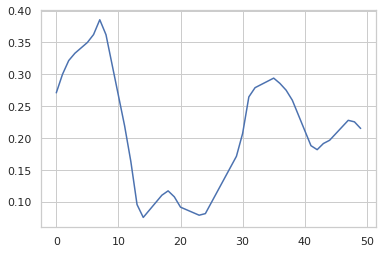

In [43]:
plt.plot(element[0][1,:,1])

In [38]:
for element,i in zip(test_data,range(20)):
    print(element[1])

tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)
tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)


In [28]:
pd.DataFrame(test_labels).value_counts()

1.0    3678
0.0    1208
2.0     256
dtype: int64

In [160]:
label2id = {"ground": 0, "silks": 1, "salto_drop": 2, "salto_pike": 3}
label2id = {"ground": 0, "silks": 1, "salto": 2}

list(label2id.keys())

['ground', 'silks', 'salto']

In [161]:
import itertools
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    cm = cm.numpy()
    
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap=plt.cm.binary)
    plt.title("Model v1 - 1s segments")
    #plt.colorbar()
    plt.grid(visible = False)
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

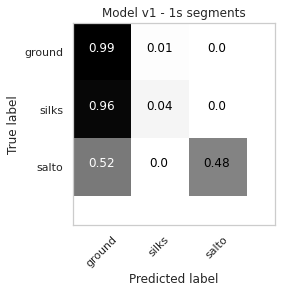

In [162]:
plot_confusion_matrix(confusion,list(label2id.keys()))

In [76]:
label2id = {"ground": 0, "silks": 1, "salto_drop": 2, "salto_pike": 3}
id2label = {v:k for k,v in label2id.items()}

In [77]:
test_decode = [id2label[i] for i in test_labels]
pred_decode = [id2label[i] for i in pred]

In [78]:
#list(zip(test_decode,pred_decode))

In [79]:
# Install xxd if it is not available
!apt-get -qq install xxd

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [80]:
# Save the file as a C source file
!xxd -i model.tflite > ./content/model.cc
# Print the source file
!cat ./content/model.cc

unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x78, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0xe0, 0x06, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x7c, 0x03, 0x00, 0x00,
  0xd4, 0x02, 0x00, 0x00, 0xa8, 0x01, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xcc, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x10, 0x28, 0x00, 0x00,
  0x0c, 0x28, 0x00, 0x00, 0x04, 0x27, 0x00, 0x00, 0x50, 0x26, 0x00, 0x00,
  0xa8, 0x25, 0x00, 0x00, 0x30, 0x25, 0x00, 0x00, 0xc4, 0x24, 0x00, 0x00,
  0x74, 0x14, 0x00, 0x00, 0x20, 0x13, 0x00, 0x00, 0xc4, 0x0f, 0x00, 0x00,
  0x68, 0x07, 0x00, 0x00, 0xe4, 0x27, 0x00, 0x00, 0xe0, 0x27, 0x00, 0x00,
  0xdc, 0x27, 0x00, 0x00, 0xd8, 0x27, 0x00, 0x00, 0xd4, 0x27, 0x00, 0x00,
  0xd